In [7]:
import pandas as pd

from dataset_utils import create_amazon_category_metadata, create_amazon_category

import matplotlib.pyplot as plt
import numpy as np
import torch
import clip
from PIL import Image
import torch.nn as nn

In [2]:
category = 'clothing_shoes_jewellery'
path_to_download = r"/home/abhinav/amazon_dataset"

amazon_category = create_amazon_category(create_amazon_category_metadata(),
                                         category,
                                         path_to_download)

Reading users.csv
Reading products.csv


In [16]:
def compute_similarity(image1_features, image2_features):
    image1_features_len = np.linalg.norm(image1_features, 2)
    image2_features_len = np.linalg.norm(image2_features, 2)
    similarity = np.dot(image1_features / image1_features_len, image2_features / image2_features_len)
    return similarity

### CLIP Embeddings

In [17]:
def compute_clip_embedding(image_path):    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    image_preprocess = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    image_features = model.encode_image( image_preprocess).cpu().detach().numpy().reshape(-1)
    return image_features

### Efficient Embeddings

In [18]:
from efficientnet_pytorch import EfficientNet
from torchvision import transforms

model = EfficientNet.from_pretrained('efficientnet-b0')

def compute_efficientnet_embedding(model, image_path):
        
    tfms = transforms.Compose([
        transforms.Resize(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img = tfms(Image.open(image_path)).unsqueeze(0)
    
    m = nn.AdaptiveAvgPool2d(output_size=1)
    
    model.eval()
    with torch.no_grad():
        features = model.extract_features(img)
        features = m(features).squeeze().cpu().detach().numpy().reshape(-1)
        
    return features



Loaded pretrained weights for efficientnet-b0


torch.Size([1, 3, 319, 224])
torch.Size([1, 3, 267, 224])
efficientnet similarity: 0.08100201189517975
clip similarity: 0.58154296875


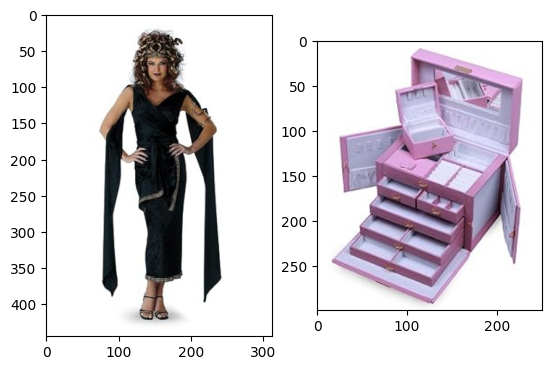

In [276]:
image1_path = amazon_category.get_product('B00004U1KF').get_image_path()
image2_path = amazon_category.get_product('0123456479').get_image_path()

plt.subplot(1, 2, 1)
plt.imshow(plt.imread(image1_path))

plt.subplot(1, 2, 2)
plt.imshow(plt.imread(image2_path))

efficientnet_image1_features = compute_efficientnet_embedding(model, image1_path)
efficientnet_image2_features = compute_efficientnet_embedding(model, image2_path)
print(f"efficientnet similarity: "
      f"{compute_similarity(efficientnet_image1_features, efficientnet_image2_features)}")

clip_image1_features = compute_clip_embedding(image1_path)
clip_image2_features = compute_clip_embedding(image2_path)
print(f"clip similarity: {compute_similarity(clip_image1_features, clip_image2_features)}")

##### Baseline efficient model is performing better than the CLIP model

### Generate embeddings

In [19]:
from dataset_utils import create_all_products_csv

category = 'clothing_shoes_jewellery'
path_to_download = r"/home/abhinav/amazon_dataset"

product_df = create_all_products_csv(create_amazon_category_metadata(),
                                     category,
                                     path_to_download)

print(f"Done!!!. Read {len(product_df)} rows")

Reading all_products.csv


Done!!!. Read 1057123 rows


In [20]:
product_df.head(100)

,asin,title,price,imUrl,brand,description,categories,category,also_viewed,also_bought,bought_together
0,0000037214,Purple Sequin Tiny Dancer Tutu Ballet Dance Fa...,6.99,http://ecx.images-amazon.com/images/I/31mCncNu...,Big Dreams,NaN,"[[Clothing, Shoes & Jewelry, Girls], [Clothing...",clothing_shoes_jewellery,[B00JO8II76],NaN,NaN
1,0000031887,Ballet Dress-Up Fairy Tutu,6.79,http://ecx.images-amazon.com/images/I/314qZjYe...,Boutique Cutie,This adorable basic ballerina tutu is perfect ...,"[[Clothing, Shoes & Jewelry, Girls, Clothing, ...",clothing_shoes_jewellery,"[B00538F5OK, B003AVKOP2, B008F0SU0Y, B002GZPTR...","[B003AVKOP2, B00D103F8U, B008F0SU0Y, B003AVEU6...",[]
2,0123456479,SHINING IMAGE HUGE PINK LEATHER JEWELRY BOX / ...,64.98,http://ecx.images-amazon.com/images/I/413tGhqo...,NaN,Elegance par excellence. Hand-crafted of the f...,"[[Clothing, Shoes & Jewelry, Novelty, Costumes...",clothing_shoes_jewellery,"[B0006JCGUM, B000BMTCK6, B00194Q262, B00AMX5QR...","[B000BMTCK6, B0006JCGUM, B00194Q262, B000P4DEY...","[B000BMTCK6, B0006JCGUM]"
3,0456844570,RiZ Women's Beautify Crafted &frac12; Rimmed F...,NaN,http://ecx.images-amazon.com/images/I/31QZTHxv...,NaN,NaN,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",clothing_shoes_jewellery,"[B004UOPY80, B00G2LY6OC, B00877BFFM, B005P1FTAK]",NaN,NaN
4,0456808574,Lantin White Visor Wrap Around Ski Style Aviat...,NaN,http://ecx.images-amazon.com/images/I/31UsrgT5...,NaN,NaN,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",clothing_shoes_jewellery,"[B005WF42SY, B003T1CFF0, B006AZCMUA, B00BD6M7P6]",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,8181475135,A1 MAX - Anime Costume Party Cosplay Short Cur...,9.99,http://ecx.images-amazon.com/images/I/41LpXQWI...,NaN,NaN,"[[Clothing, Shoes & Jewelry, Novelty, Costumes...",clothing_shoes_jewellery,"[B008IG6L2O, B007JEHD5A, B0085J7ITE, B006DWABX...","[B006DWABXA, B0085J7ITE, B00EN6QXI0, B0091V7V7...",[B006DWABXA]
96,8279996834,Blessed by Pope Benedetto Armed Forces Wallet ...,9.99,http://ecx.images-amazon.com/images/I/41tlqQpH...,NaN,NaN,"[[Clothing, Shoes & Jewelry, Women], [Clothing...",clothing_shoes_jewellery,[B0007PNK1Y],NaN,NaN
97,8511000135,Genuine Azabache Against Evil Eye Azabache &am...,9.99,http://ecx.images-amazon.com/images/I/31cHwtHv...,Gifts by Lulee/Baby,"In Latin America, Azabaches are worn to protec...","[[Clothing, Shoes & Jewelry, Novelty, Costumes...",clothing_shoes_jewellery,"[B00EG8ZFJI, B00G7KPRNC, B002QSTHEE, B005G8BH0...","[B005G8BH0I, B002QSTHEE]",[B005G8BH0I]
98,8742245095,Black Leather Smartphone Accordion Wallet Purse,NaN,http://ecx.images-amazon.com/images/I/41u8mud4...,NaN,NaN,"[[Clothing, Shoes & Jewelry, Women, Handbags &...",clothing_shoes_jewellery,"[B003SB5HK6, B00BCA34W8]",NaN,NaN


In [21]:
import pandas as pd
import os

errors = []
def compute_embedding(row):
    asin = row['asin']
    imUrl = row['imUrl']
    
    try:
        if pd.isna(imUrl):
            errors.append(f"Image not found for asin: {asin}")
            return np.nan
        
        image_path = os.path.join(path_to_download, category, "images", os.path.basename(imUrl))

        if not os.path.exists(image_path):
            errors.append(f"Image path not found for asin: {asin}, location: {image_path}")
            return np.nan
        else:
            return compute_efficientnet_embedding(model, image_path)
    except:
        errors.append(f"Error in computing embedding for asin: {asin}")
        return np.nan
         
product_df['image_embedding'] = product_df.apply(compute_embedding, axis=1)
product_df['image_embedding'].head()

0    [-0.17671323, -0.15239318, -0.13925381, -0.180...
1    [-0.15978312, -0.21616973, -0.13822936, -0.071...
2    [-0.12111257, -0.11473565, -0.08827221, -0.106...
3    [-0.10899078, -0.0903305, -0.15802173, -0.1202...
4    [-0.15257351, -0.061475337, -0.13804054, 0.191...
Name: image_embedding, dtype: object

In [11]:
category = 'clothing_shoes_jewellery'
path_to_download = r"/home/abhinav/amazon_dataset"

embedding_filename = os.path.join(path_to_download, category, "product_image_embeddings.csv")
product_embedding_df = product_df[['asin', 'image_embedding']]

# Remove rows with na
product_embedding_df = product_embedding_df[~product_embedding_df['image_embedding'].isna()]
product_embedding_df.to_csv(embedding_filename, index=False)

NameError: name 'product_df' is not defined

In [15]:
dup_product_embedding.dtypes

asin               object
image_embedding    object
dtype: object

In [12]:
import os
import ast

embedding_filename = os.path.join(path_to_download, category, "product_image_embeddings.csv")
dup_product_embedding = pd.read_csv(embedding_filename)
dup_product_embedding.head()

,asin,image_embedding
0,0000037214,[-0.17671323 -0.15239318 -0.13925381 ... -0.20...
1,0000031887,[-0.15978312 -0.21616973 -0.13822936 ... -0.06...
2,0123456479,[-0.12111257 -0.11473565 -0.08827221 ... -0.04...
3,0456844570,[-0.10899078 -0.0903305 -0.15802173 ... 1.14...
4,0456808574,[-0.15257351 -0.06147534 -0.13804054 ... 1.09...


In [15]:
dup_product_embedding['image_embedding'].iloc[0]

'[-0.17671323 -0.15239318 -0.13925381 ... -0.20362784 -0.08735325\n  0.13296957]'

In [ ]:
product_embedding_df =  product_df[['asin', 'image_embedding']]
product_embedding_df = product_embedding_df[~product_embedding_df['image_embedding'].isna()]
product_embedding_df['image_embedding'] = product_embedding_df['image_embedding'].apply(lambda x: x.tolist())
embedding_filename = os.path.join(path_to_download, category, "product_image_embeddings.parquet")
product_embedding_df.to_parquet(embedding_filename, engine='parquet')

In [11]:
product_embedding_df.head()

NameError: name 'product_embedding_df' is not defined

In [17]:
test_df = product_df[['asin', 'image_embedding']].head()
test_df['image_embedding'] = test_df['image_embedding'].apply(lambda x: x.tolist())
test_df.to_parquet(embedding_filename, engine='fastparquet')

In [ ]:
product_embedding_df[~product_embedding_df['image_embedding'].isna()]